IMPORTING LIBRARIES

In [318]:
# Filtering Warnings
import warnings
warnings.filterwarnings('ignore')

#Import Libraries
import numpy as np
import pandas as pd
#import seaborn as sns
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pd.set_option('display.max_columns', 300) #Setting column display limit
plt.style.use('ggplot') #Applying style to graphs

LOAD DATA

In [319]:

app_df = pd.read_parquet('data/application_data.parquet')

DATA PRE-PROCESSING

In [ ]:

app_df.shape

In [ ]:

app_df.head()

In [ ]:
app_df.describe()

NULL CHECKING AND HANDLING

In [ ]:
#null checking

(app_df.isnull().sum()/len(app_df)*100).sort_values(ascending = False).head(50)

It is evident that there are lots of columns with missing values. We need to investigate further and drop columns with null values higher than 40%.

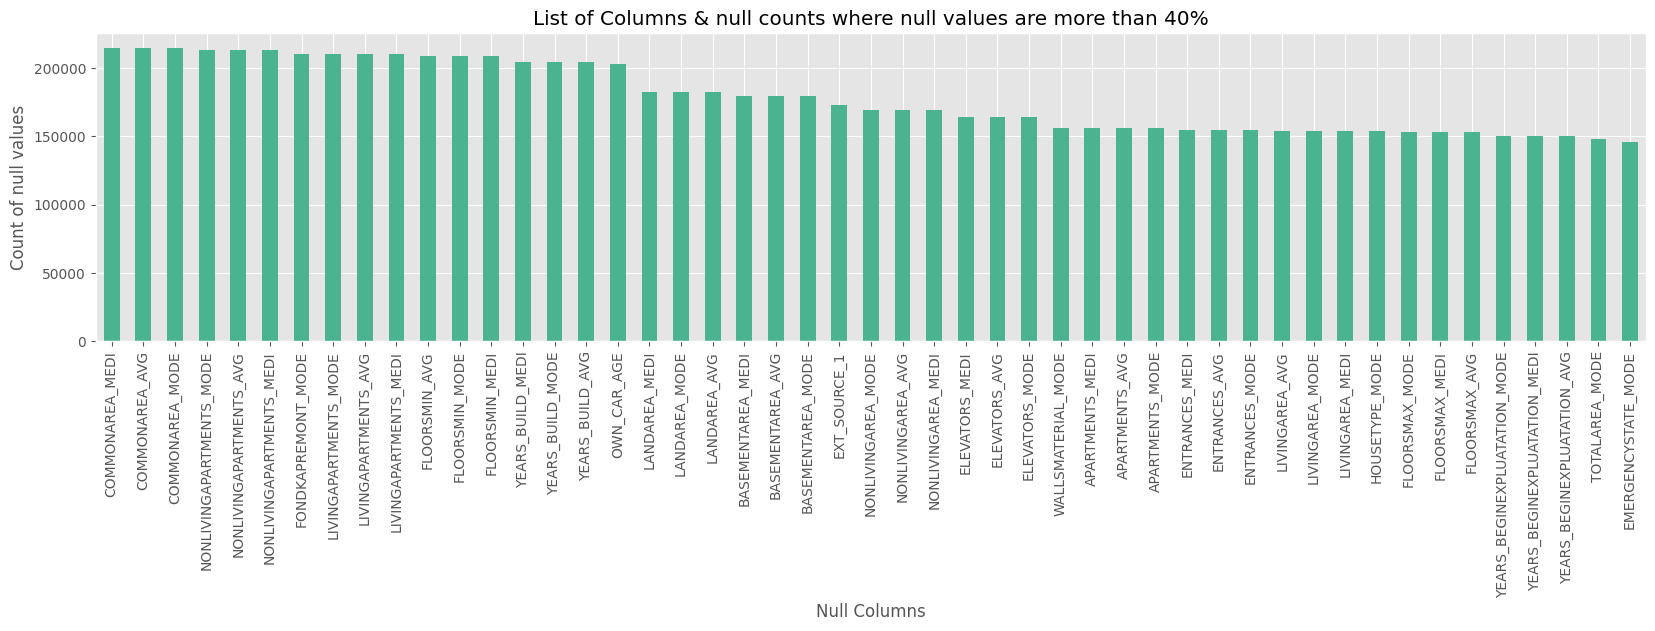

In [320]:
null_col = app_df.isnull().sum().sort_values(ascending = False)
null_col = null_col[null_col.values >(0.40*len(app_df))]


#Plotting Bar Graph for null values greater than 40%

plt.figure(figsize=(20,4))
null_col.plot(kind='bar', color="#4CB391")
plt.title('List of Columns & null counts where null values are more than 40%')

plt.xlabel("Null Columns",fontdict={"fontsize":12,"fontweight":5})
plt.ylabel("Count of null values",fontdict={"fontsize":12,"fontweight":5})
plt.show()

In [ ]:
len(null_col)

CORRELATION ANALYSIS

In [321]:
#Correlated columns with target

correlation=app_df.corr(numeric_only=True)
top_positive_corr = correlation.TARGET.sort_values(ascending=False).head(5).index.to_list()
top_negative_corr = correlation.TARGET.sort_values(ascending=True).head(5).index.to_list()
print(top_positive_corr)
print(top_negative_corr)

['TARGET', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE']
['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'FLOORSMAX_AVG']


In [322]:
top_corr_columns = []
top_corr_columns = top_positive_corr + top_negative_corr
print(top_corr_columns)

['TARGET', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_EMPLOYED', 'FLOORSMAX_AVG']


In [323]:
cols_to_drop = list(null_col.index.values) #Making list of column names having null values greater than 40%

In [324]:
#Removing top correlated columns from columns to be dropped

for col in top_corr_columns:
    if col in cols_to_drop:
        cols_to_drop.remove(col)
        print(col)

EXT_SOURCE_1
FLOORSMAX_AVG


In [ ]:
len(cols_to_drop)

In [325]:
app_df.drop(labels = cols_to_drop,axis=1,inplace = True) #Dropping those columns

In [326]:
app_df = app_df[top_corr_columns]

In [ ]:
app_df.shape

In [327]:
#Checking for left-out columns with null

null_left = (app_df.isnull().sum()/len(app_df)*100).sort_values(ascending = False).head(20)
null_left

EXT_SOURCE_1                   56.381073
FLOORSMAX_AVG                  49.760822
EXT_SOURCE_3                   19.825307
EXT_SOURCE_2                    0.214626
DAYS_LAST_PHONE_CHANGE          0.000325
TARGET                          0.000000
DAYS_BIRTH                      0.000000
REGION_RATING_CLIENT_W_CITY     0.000000
REGION_RATING_CLIENT            0.000000
DAYS_EMPLOYED                   0.000000
dtype: float64

Filling null values

In [328]:
app_df.EXT_SOURCE_3.fillna(app_df.EXT_SOURCE_3.median() , inplace = True)

app_df.EXT_SOURCE_2.fillna(app_df.EXT_SOURCE_2.median() , inplace = True)

app_df.EXT_SOURCE_1.fillna(app_df.EXT_SOURCE_1.median() , inplace = True)

In [329]:
#Since this is an average computation based column, hence we fill NaN values with median

app_df['FLOORSMAX_AVG'].fillna(app_df['FLOORSMAX_AVG'].median(),inplace=True)

In [330]:
#replace few missing values with Mode (the average value)

app_df['DAYS_LAST_PHONE_CHANGE'].fillna(757, inplace=True)

In [ ]:
app_df.head()

In [331]:
#DAYS columns will be standardized by taking absolute values

app_df_days = [i for i in app_df if i.startswith('DAYS')]

app_df[app_df_days] = abs(app_df[app_df_days])
app_df[app_df_days].head()

,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED
0,9461,1134.0,637
1,16765,828.0,1188
2,19046,815.0,225
3,19005,617.0,3039
4,19932,1106.0,3038


In [ ]:
null_check = (app_df.isnull().sum()/len(app_df)*100).sort_values(ascending = False)
null_check

No further missing values

FEATURE ENGINEERING - BINNING AND GROUPING

In [ ]:
app_df.head()

In [332]:
#DAYS_BIRTH

app_df['DAYS_BIRTH']= (app_df['DAYS_BIRTH']/365).astype(int)
app_df['DAYS_BIRTH'].unique()

array([25, 45, 52, 54, 46, 37, 51, 55, 39, 27, 36, 38, 23, 35, 26, 48, 31,
       50, 40, 30, 68, 43, 28, 41, 32, 33, 47, 57, 65, 44, 64, 21, 59, 49,
       56, 62, 53, 42, 29, 67, 63, 61, 58, 60, 34, 22, 24, 66, 69, 20])

In [333]:
#DAYS_EMPLOYED
app_df['AGE_GROUP']=pd.cut(app_df['DAYS_BIRTH'],
                         bins=[19,25,40,60,100], labels=['Very_Young','Youth', 'Middle_Age', 'Elder'])

In [334]:
#replace 365243 as 0 because it represent unemployed values
app_df['DAYS_EMPLOYED_YEARS'] = (app_df['DAYS_EMPLOYED'].replace(365243, 0))
app_df['DAYS_EMPLOYED_YEARS']= (app_df['DAYS_EMPLOYED_YEARS']/365).astype(int)
app_df['DAYS_EMPLOYED_YEARS'].unique()

array([ 1,  3,  0,  8,  4,  5,  7, 21, 11,  2,  9, 12, 14, 26, 19,  6, 10,
       13, 24, 18, 23, 15, 22, 27, 32, 20, 25, 42, 16, 30, 38, 33, 17, 31,
       28, 29, 36, 34, 40, 39, 35, 37, 41, 44, 43, 48, 46, 45, 47, 49])

In [335]:
bins = [0, 1, 5, 10, 20, 30, 40, 50]
labels = ['unemployed and <1 yr', '1-5 yrs', '5-10 yrs', '10-20 yrs', '20-30 yrs', '30-40 yrs', '40-50 yrs']

app_df['YEARS_EMPLOYED_GROUP'] = pd.cut(app_df['DAYS_EMPLOYED_YEARS'], bins=bins, labels=labels, right=False)

In [336]:
#DAYS_LAST_PHONE_CHANGE

app_df['DAYS_LAST_PHONE_CHANGE_YEARS'] = round(app_df['DAYS_LAST_PHONE_CHANGE'] / 365)
app_df['DAYS_LAST_PHONE_CHANGE_YEARS'].unique()

array([ 3.,  2.,  7.,  4.,  0.,  5.,  6.,  1.,  8.,  9., 11., 10., 12.])

In [337]:
bins = [-1, 1, 4, float('inf')]
labels = ['Recent', 'Moderate', 'Old']
app_df['PHONE_CHANGE_GROUP'] = pd.cut(app_df['DAYS_LAST_PHONE_CHANGE_YEARS'], bins=bins, labels=labels)

    RE-CONFIRMING DATASET AFTER BINNING

In [338]:
app_df.head()

,TARGET,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,DAYS_EMPLOYED,FLOORSMAX_AVG,AGE_GROUP,DAYS_EMPLOYED_YEARS,YEARS_EMPLOYED_GROUP,DAYS_LAST_PHONE_CHANGE_YEARS,PHONE_CHANGE_GROUP
0,1,25,2,2,1134.0,0.139376,0.262949,0.083037,637,0.0833,Very_Young,1,1-5 yrs,3.0,Moderate
1,0,45,1,1,828.0,0.535276,0.622246,0.311267,1188,0.2917,Middle_Age,3,1-5 yrs,2.0,Moderate
2,0,52,2,2,815.0,0.729567,0.555912,0.505998,225,0.1667,Middle_Age,0,unemployed and <1 yr,2.0,Moderate
3,0,52,2,2,617.0,0.535276,0.650442,0.505998,3039,0.1667,Middle_Age,8,5-10 yrs,2.0,Moderate
4,0,54,2,2,1106.0,0.535276,0.322738,0.505998,3038,0.1667,Middle_Age,8,5-10 yrs,3.0,Moderate


In [339]:
#Drop these columns to prevent multi-collinearity

app_df.drop(columns=['DAYS_EMPLOYED', 'DAYS_EMPLOYED_YEARS','DAYS_BIRTH','DAYS_LAST_PHONE_CHANGE_YEARS','DAYS_LAST_PHONE_CHANGE'], inplace=True)

In [340]:
app_df.head()

,TARGET,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,FLOORSMAX_AVG,AGE_GROUP,YEARS_EMPLOYED_GROUP,PHONE_CHANGE_GROUP
0,1,2,2,0.139376,0.262949,0.083037,0.0833,Very_Young,1-5 yrs,Moderate
1,0,1,1,0.535276,0.622246,0.311267,0.2917,Middle_Age,1-5 yrs,Moderate
2,0,2,2,0.729567,0.555912,0.505998,0.1667,Middle_Age,unemployed and <1 yr,Moderate
3,0,2,2,0.535276,0.650442,0.505998,0.1667,Middle_Age,5-10 yrs,Moderate
4,0,2,2,0.535276,0.322738,0.505998,0.1667,Middle_Age,5-10 yrs,Moderate


EXPLORATORY DATA ANALYSIS

In [341]:
#DATA IMBALANCE CHECK

target_counts = app_df['TARGET'].value_counts()
target_counts

TARGET
0    282686
1     24825
Name: count, dtype: int64

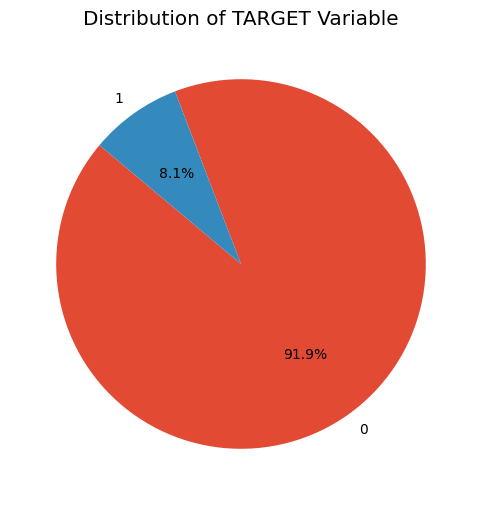

In [342]:
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of TARGET Variable')
plt.show()

This reveals that 8.1% of the dataset are defaulting customers while 91.9% are not.

In [343]:
Target0 = app_df.loc[app_df["TARGET"]==0]
Target1 = app_df.loc[app_df["TARGET"]==1]

round(len(Target0)/len(Target1),2)

11.39

The imbalance ratio of non-defaulters to defaulter is "11.39". This simply means for every one defaulter, there is approximately 11 non-defaulters. Hence, ROC AUC curve will be better suited to evaluate selected models in predictive modelling section.

UNIVARIATE ANALYSIS

In [344]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       307511 non-null  int64   
 1   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64   
 2   REGION_RATING_CLIENT         307511 non-null  int64   
 3   EXT_SOURCE_3                 307511 non-null  float64 
 4   EXT_SOURCE_2                 307511 non-null  float64 
 5   EXT_SOURCE_1                 307511 non-null  float64 
 6   FLOORSMAX_AVG                307511 non-null  float64 
 7   AGE_GROUP                    307511 non-null  category
 8   YEARS_EMPLOYED_GROUP         307511 non-null  category
 9   PHONE_CHANGE_GROUP           307511 non-null  category
dtypes: category(3), float64(4), int64(3)
memory usage: 17.3 MB


In [345]:
app_df.shape

(307511, 10)

MODELLING

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
import pickle
import gc

In [ ]:
model_df = app_df.drop(['SK_ID_CURR'],axis=1)

In [ ]:
model_df.head()

In [ ]:
y_label = model_df.pop('TARGET').values

In [ ]:
y_label

In [ ]:
model_df.head()

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(model_df, y_label, stratify = y_label, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

STANDARDIZATION

In [ ]:
# Seperation of columns into numeric and categorical columns
num_cols = np.array(X_train.select_dtypes(include= ['int64','float64']).columns)
cat_cols = np.array(X_train.select_dtypes(include= ['category','object']).columns)

In [ ]:
#NUMERIC COLUMN STANDARDIZATION
X_train_num = X_train[num_cols]
X_val_num = X_val[num_cols]
X_test_num = X_test[num_cols]


#SCALING
scaler_num = StandardScaler()
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_val_num_scaled = scaler_num.transform(X_val_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

X_train_num_final = pd.DataFrame(X_train_num_scaled, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num_scaled, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num_scaled, columns=num_cols)

In [ ]:
#CATEGORICAL COLUMN STANDARDIZATION

X_train_cat = X_train[cat_cols]
X_val_cat = X_val[cat_cols]
X_test_cat = X_test[cat_cols]

X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)

#ONE HOT ENCODING
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)

cat_cols_ohe = list(ohe.get_feature_names_out(input_features=cat_cols))
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)

In [ ]:
# STANDARDIZED DATA

X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

In [ ]:
#RENAMING SPECIAL CHARACTER COLUMN NAMES

import re
X_train_final = X_train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val_final = X_val_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_final = X_test_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

MODELLING DATA SAVING

In [ ]:
# Saving the Dataframes into CSV files
X_train_final.to_csv('X_train_final.csv')
X_val_final.to_csv('X_val_final.csv')
X_test_final.to_csv('X_test_final.csv')
# Saving the numpy arrays into text files
np.savetxt('y_label.txt', y_label)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)

FEATURE SELECTION

In [ ]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000,
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1, early_stopping_rounds=100)

train_features, val_features, train_y, val_y = train_test_split(X_train_final, y_train, test_size = 0.15, random_state = 42)

model_sk.fit(train_features, train_y, eval_set = [(val_features, val_y)], eval_metric = 'auc')

In [ ]:
#FEATURE IMPORTANCE

feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])

# Save selected features into pickle file
with open('select_features.txt','wb') as pf:
    pickle.dump(selected_features, pf)
print('The no. of features selected:',len(selected_features))

In [ ]:
# Feature importance Plot

top50_features = features_df.head(50)

# Create a data frame for visualization.
top50_features_df = pd.DataFrame({"Features": pd.DataFrame(top50_features).sort_values(by='Value')['Feature'],
                                  "Importances": top50_features.sort_values(by='Value')['Value']})

# Plot the feature importances in bars.
plt.figure(figsize=(19, 6))
plt.bar(top50_features_df['Features'], top50_features_df['Importances'], color='teal')
plt.xticks(rotation=90)
plt.title("Top 50 Important Features")
plt.show()

RE-USABLE PLOT FUNCTIONS

In [ ]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)

    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)

    # Precision matrix
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(20,4))

    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion matrix')

    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Recall matrix')

    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Precision matrix')

    plt.show()

In [ ]:
def cv_plot(alpha, cv_auc):

    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

ML MODELS

In [ ]:
model_results = [[],[],[]]

In [ ]:
#LOGISTIC REGRESSION

alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log_loss', random_state=28)
    clf.fit(X_train_final[selected_features], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_final[selected_features], y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])

In [ ]:
best_alpha = alpha[np.argmax(cv_auc_score)]
logreg = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', penalty = 'l1', loss='log_loss', random_state = 28)
logreg.fit(X_train_final[selected_features], y_train)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid')
logreg_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = logreg_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob)))
model_results[0].append(roc_auc_score(y_train,y_pred_prob))
y_pred_prob = logreg_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob)))
model_results[0].append(roc_auc_score(y_val,y_pred_prob))
y_pred_prob = logreg_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob)))
model_results[0].append(roc_auc_score(y_test,y_pred_prob))
y_pred = logreg.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The test accuracy score is :', accuracy_score(y_test, y_pred))
model_results[0].append(accuracy_score(y_test,y_pred))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
#RANDOM FOREST CLASSIFIER

alpha = [200,500,1000]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final[selected_features], y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final[selected_features], y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))

In [ ]:
best_alpha = np.argmax(cv_auc_score)
print('The optimal values are: n_estimators {0}, max_depth {1} '.format(alpha[int(best_alpha/2)],
                                                                        max_depth[int(best_alpha%2)]))
rf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_final[selected_features], y_train)
rf_sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
rf_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = rf_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                    max_depth[int(best_alpha%2)],roc_auc_score(y_train,y_pred_prob)))
model_results[1].append(roc_auc_score(y_train,y_pred_prob))
y_pred_prob = rf_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                            max_depth[int(best_alpha%2)],roc_auc_score(y_val,y_pred_prob)))
model_results[1].append(roc_auc_score(y_val,y_pred_prob))
y_pred_prob = rf_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                        max_depth[int(best_alpha%2)],roc_auc_score(y_test,y_pred_prob)))
model_results[1].append(roc_auc_score(y_test,y_pred_prob))
y_pred = rf_sig_clf.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The accuracy score is :', accuracy_score(y_test, y_pred))
model_results[1].append(accuracy_score(y_test,y_pred))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
#LIGHTGBM

weight = np.ones((len(X_train_final),), dtype=int)
for i in range(len(X_train_final)):
    if y_train[i]== 0:
        weight[i]=1
    else:
        weight[i]=11

train_data=lgb.Dataset(X_train_final[selected_features], label = y_train, weight= weight )
valid_data=lgb.Dataset(X_val_final[selected_features], label = y_val)
cv_auc_score = []
max_depth = [3, 5, 7, 10]
for i in max_depth:

    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
              train_data,
              2500,
              valid_sets=valid_data
              )
y_pred_prob = lgbm.predict(X_val_final[selected_features])
cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])
params = {'boosting_type': 'gbdt',
      'max_depth' : max_depth[np.argmax(cv_auc_score)],
      'objective': 'binary',
      'nthread': 5,
      'num_leaves': 32,
      'learning_rate': 0.05,
      'max_bin': 512,
      'subsample_for_bin': 200,
      'subsample': 0.7,
      'subsample_freq': 1,
      'colsample_bytree': 0.8,
      'reg_alpha': 20,
      'reg_lambda': 20,
      'min_split_gain': 0.5,
      'min_child_weight': 1,
      'min_child_samples': 10,
      'scale_pos_weight': 1,
      'num_class' : 1,
      'metric' : 'auc'
      }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data
                 )
y_pred_prob = lgbm.predict(X_train_final[selected_features])
print('For best max_depth {0}, The Train AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)],
                                                                  roc_auc_score(y_train,y_pred_prob) ))
model_results[2].append(roc_auc_score(y_train,y_pred_prob))
y_pred_prob = lgbm.predict(X_val_final[selected_features])
print('For best max_depth {0}, The Cross validated AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)],
                                                                            roc_auc_score(y_val,y_pred_prob) ))
model_results[2].append(roc_auc_score(y_val,y_pred_prob))
y_pred_prob = lgbm.predict(X_test_final[selected_features])
print('For best max_depth {0}, The Test AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)],
                                                                 roc_auc_score(y_test,y_pred_prob) ))
model_results[2].append(roc_auc_score(y_test,y_pred_prob))
y_pred = np.ones((len(X_test_final),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The accuracy score is :', accuracy_score(y_test, y_pred))
model_results[2].append(accuracy_score(y_test,y_pred))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
eval_score = pd.DataFrame(model_results, columns=['Train AUC','Cross Val AUC','Test AUC','Accuracy'], index=['Logistic Regression','Random Forest','LightGBM'])
eval_score

In [ ]:
# Saving the best performing LightGBM model as a pickle file for the future use
with open('final_model.pkl','wb') as fp:
    pickle.dump(lgbm, fp)